# Exotic pricing with multidimensional non-linear interpolation

## Introduction

Autocallable products are structured products, offering attractive fixed yields with the combinaison of options payoff. Given the extremely low levels of interest rates and market uncertainties, many investors are attracted by the combination of fixed yields above market rates and some form of capital protection. We focused in this project in a particular type of derivative product, called the Autocallable Reverse Convertible.

The aim of the project is to price this product using real market data prices with the corresponding parameters.

###### Parameters 

- S1, S2, S3: 3 underlyings (equities assets for example)
- $\mu_1$, $\mu_2$, $\mu_3$: their drift rate
- $\sigma_{1}$, $\sigma_{2}$, $\sigma_{3}$: their volatilities
- $\rho_{12}$, $\rho_{13}$, $\rho_{23}$: their correlations
- Bonus: Coupon paid at the end of every period until the deal is either terminated or recalled 

- YetiBarrier: Barrier on the worst of the three underlyings above which we Yeti coupon is paid 

- YetiCoupon: Yeti coupon 

- PhoenixBarrier: Barrier on the worst of the three underlyings which triggers the recall of the deal 

- PhoenixCoupon: Coupon paid when the recall happens to compensate for the lost Yeti and Bonus coupons 

- PDIBarrier: Barrier of put down and in (PDI) options at maturity if no recall has happened 

- PDIGearing: Number of PDI options for 1 unit of notional of the deal 

- PDIStrike: Strike of PDI 
 
- PDIType: Coefficient inside the option payoff , -1 for a put and +1 for a call 

- Maturity: Maturity of the deal 

- NbDates: Number of reset dates of the autocall

###### Description

- First, if at a certain datet i, the worst underlying is above the Phenix barrier, then the product is recalled: the customer touch a coupon called coupon Phoenix.

- As long as the product has not been recalled, there are two cases: Either the price of the worst underlying remains between the barriers Yéti and Phœnix, in this case the investor touches a fixed coupon called coupon Yéti, or the price of the worst underlying descends below the Yeti barrier, and in this case the investor does not receive any coupon.
- Finally, if the product has not been recalled, there are several cases at maturity: If the price of the underlying is above the Phoenix barrier, the customer touches a coupon Phoenix and the payoff of a call (or put). If the underlying price is between the Yéti and Phoenix barriers, the customer touches a Yeti coupon and the payoff of a call (or put). If the price of the underlying is included between the PDI and Yeti barriers, the customer recovers only the payoff of a call (or put). Finally, if the underlying subperforms below the PDI barrier, the client touches nothing.

###### Notebook structure

- Data analysis : we look at the data (correlation with price, plot)
- Naive benchmark : we run a linear regression with forward selection to obtain the most important parameters
- Running different algorithms with cross validation : polynomial regression, KNN for regression, random/extra tree, adaboost (all with cross validation to fine tune their main parameters, and with a plot of their error against each feature)
- Neural network : we selected to best features and then fine tuned the hyperparamters of a 4 hidden layers architecture.
- Stacking : we stack neural network, adaboost and extra trees algorithms to imporve the performance
- Submission : we finally submit our best model on enschallenge website

## Data analysis

In [41]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from vecstack import stacking
import itertools
import random
import time
import os

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adamax
from sklearn.preprocessing import MinMaxScaler

Import dataset :

In [3]:
x_train = pd.read_csv("training_input_mtaTRFH.csv")
x_train = x_train.drop(['ID'], axis=1)
y_train = pd.read_csv("training_output_aq7NYgj.csv")
y_train = y_train['Target']

n = len(y_train)
p = len(x_train.columns)

Look if there is empty value in the dataset :

In [4]:
train_set = x_train.copy()
train_set['Price'] = y_train
train_set.isnull().values.any() 

False

Look at a summary of the parameter :

In [5]:
train_set.describe()

,S1,S2,S3,mu1,mu2,mu3,sigma1,sigma2,sigma3,rho12,...,YetiCoupon,PhoenixBarrier,PhoenixCoupon,PDIBarrier,PDIGearing,PDIStrike,PDIType,Maturity,NbDates,Price
count,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,...,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,4.413879e-01,0.441591,0.441705,0.499664,5.004757e-01,0.499759,5.001345e-01,4.999336e-01,0.499998,0.468103,...,0.500395,5.000002e-01,0.500098,0.500606,0.499387,4.999562e-01,0.500363,0.499807,0.500046,0.466824
std,2.200409e-01,0.220160,0.220295,0.288685,2.886304e-01,0.288562,2.887518e-01,2.885372e-01,0.288376,0.269332,...,0.288025,2.887136e-01,0.288720,0.289789,0.288817,2.886119e-01,0.288718,0.288660,0.289403,0.035855
min,3.320000e-07,0.000004,0.000010,0.000000,9.800000e-07,0.000000,6.270000e-07,4.530000e-07,0.000001,0.000000,...,0.000000,7.640000e-07,0.000000,0.000000,0.000000,9.450000e-07,0.000000,0.000000,0.000000,0.000000
25%,3.506395e-01,0.350624,0.350617,0.249592,2.504906e-01,0.250209,2.499167e-01,2.497081e-01,0.250519,0.239759,...,0.251524,2.499421e-01,0.250154,0.248624,0.249149,2.498464e-01,0.250279,0.249696,0.250000,0.448888
50%,3.838440e-01,0.383832,0.383871,0.499279,5.005657e-01,0.499527,4.999394e-01,5.002905e-01,0.499939,0.464223,...,0.500702,5.004242e-01,0.500054,0.501166,0.499087,5.000198e-01,0.500267,0.499883,0.500000,0.459273
75%,5.284078e-01,0.528887,0.530300,0.750030,7.506226e-01,0.749583,7.502722e-01,7.498133e-01,0.749428,0.690272,...,0.749857,7.500166e-01,0.749842,0.752276,0.749765,7.500573e-01,0.750566,0.749642,0.750000,0.476683
max,9.999981e-01,0.999999,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,9.999986e-01,1.000000,0.999869,...,1.000000,1.000000e+00,1.000000,1.000000,0.999999,1.000000e+00,1.000000,1.000000,1.000000,0.967344


We first check correlation between all the variables :

In [6]:
from IPython.display import display

pd.options.display.max_columns = None

train_set.corr()

,S1,S2,S3,mu1,mu2,mu3,sigma1,sigma2,sigma3,rho12,rho13,rho23,Bonus,YetiBarrier,YetiCoupon,PhoenixBarrier,PhoenixCoupon,PDIBarrier,PDIGearing,PDIStrike,PDIType,Maturity,NbDates,Price
S1,1.000000,0.080773,0.079631,0.000302,-0.000880,-0.000873,0.000425,-0.000695,-0.000580,-0.000736,0.000600,-0.000212,0.001005,0.000056,0.000432,0.001280,-0.000020,-0.001233,0.000801,-0.000872,-0.001092,-0.001338,0.001899,-0.076871
S2,0.080773,1.000000,0.080510,0.000411,0.000661,-0.001866,0.001120,0.000588,0.001016,0.000508,-0.000219,0.001702,0.000925,-0.000067,0.000235,0.000683,-0.000696,-0.000789,0.000862,-0.000296,0.000719,0.000666,-0.000412,-0.077972
S3,0.079631,0.080510,1.000000,0.000950,0.000108,-0.000754,0.000125,0.000582,-0.001282,0.000162,0.001036,-0.000686,-0.000052,0.000207,0.000780,0.001015,0.001086,-0.001348,-0.000154,0.000467,-0.002248,-0.000244,0.001063,-0.078488
mu1,0.000302,0.000411,0.000950,1.000000,-0.000142,-0.000131,0.000192,0.001253,-0.002310,0.002967,0.001640,0.000576,-0.000801,-0.001112,-0.001212,-0.000364,0.000128,-0.000030,-0.000430,-0.000189,-0.000334,0.001173,-0.000483,-0.006442
mu2,-0.000880,0.000661,0.000108,-0.000142,1.000000,0.000789,0.000294,0.000963,0.001481,0.002354,-0.001349,0.001929,0.001055,-0.000415,-0.000344,0.000475,0.000106,-0.001116,0.000229,-0.001494,-0.000856,-0.001281,-0.000182,-0.005794
mu3,-0.000873,-0.001866,-0.000754,-0.000131,0.000789,1.000000,-0.001999,0.000264,0.000919,-0.001344,0.000580,-0.000532,-0.001271,-0.000720,0.000851,-0.000713,0.000108,-0.000776,0.000992,0.001638,-0.000448,-0.000453,-0.000204,-0.006706
sigma1,0.000425,0.001120,0.000125,0.000192,0.000294,-0.001999,1.000000,-0.000829,-0.000684,-0.000243,-0.000738,-0.002366,0.001073,-0.001956,0.001349,0.002224,0.002009,-0.001057,-0.000048,0.000265,0.001224,-0.000088,0.000387,0.006480
sigma2,-0.000695,0.000588,0.000582,0.001253,0.000963,0.000264,-0.000829,1.000000,0.001895,-0.002259,0.000949,0.000650,-0.000161,0.001509,-0.001477,0.000302,-0.001180,0.000051,-0.000718,-0.000707,0.000370,-0.002493,-0.001230,0.002401
sigma3,-0.000580,0.001016,-0.001282,-0.002310,0.001481,0.000919,-0.000684,0.001895,1.000000,-0.000658,-0.001571,-0.000637,-0.000576,-0.000511,-0.000809,0.001086,-0.000628,-0.000080,-0.000200,-0.000050,-0.000169,0.000659,0.000769,0.003868
rho12,-0.000736,0.000508,0.000162,0.002967,0.002354,-0.001344,-0.000243,-0.002259,-0.000658,1.000000,0.039754,0.039173,0.000906,-0.001516,0.000761,-0.000109,-0.000291,0.000069,0.001156,-0.002157,0.000123,-0.000362,0.000131,-0.007016


Bonus, YetiCoupon, PDIGearing, NbDates and PhoenixBarrier are the most correlated parameters ranked in ascending order with the variable Price. All of the varibale seems not relevant.

We plot each of the parameter against Y (Price) : 

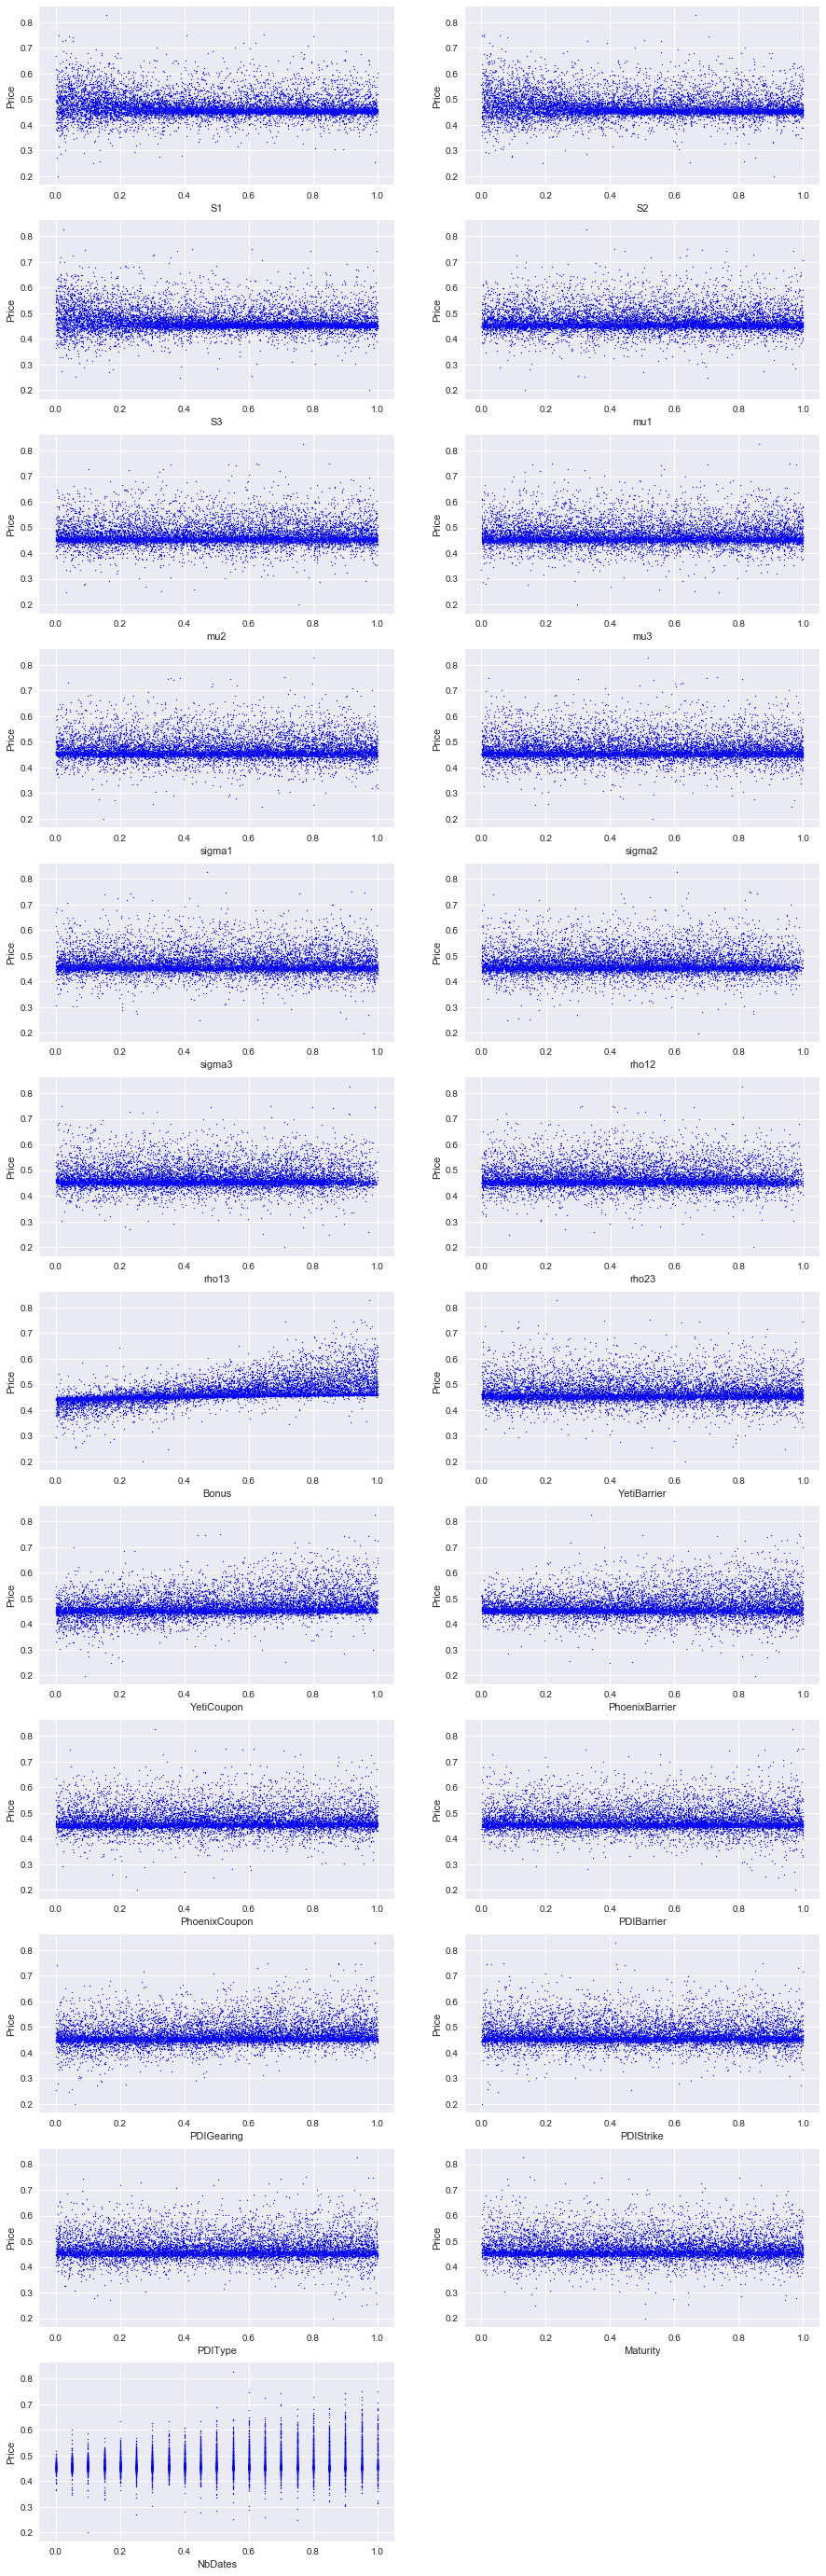

In [7]:
fig = plt.figure(figsize=(15,50))

for index,i in enumerate(x_train.columns):
    
    fig.add_subplot(12, 2, index+1)
    plt.scatter(train_set[i][0:10**4], y_train[0:10**4], s=1, c='b') # check for 10 000 observations to obtain useful graphs 
    plt.xlabel(i)
    plt.ylabel("Price")
    
plt.show()

We define a function to plot the residual error against each feature :

In [6]:
def plot_nn_residual_error(model, x_val, y_val):
    """
    Graph of the error (y-y_true) against each features
    
    model : a neural network model we have to used to obtain the prédiction of the price y
    x_val : features validation set
    y_val : price validation set
    """
    
    fig = plt.figure(figsize=(15,50))
    pred = [i[0] for i in model.predict(x_val)]
    for index,feature in enumerate(x_val.columns):
        fig.add_subplot(int(len(x_val.columns)/2)+1, 2, index+1)
        plt.scatter(x_val[feature], pred-y_val, s=1, c='b')
        plt.xlabel(feature)
        plt.ylabel("Residual error")
    plt.show()

def plot_residual_error(model, x_val, y_val):
    """
    Graph of the error (y-y_true) against each features
    
    model : any model other than neural network we have to used to obtain the prédiction of the price y
    x_val : features validation set
    y_val : price validation set
    """
    
    fig = plt.figure(figsize=(15,50))
    pred = model.predict(x_val)
    for index,feature in enumerate(x_val.columns):
        fig.add_subplot(int(len(x_val.columns)/2)+1, 2, index+1)
        plt.scatter(x_val[feature], pred-y_val, s=1, c='b')
        plt.xlabel(feature)
        plt.ylabel("Residual error")
    plt.show()

## Benchmark

Before running our algorithms, we split the dataset into 3 fold

In [5]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

Useful function : MSE (loss function)

In [9]:
def MSE(y, ypred):
    size = y.size
    return np.sum((y-ypred)**2)/size

def MSE_cross_val(x_train, y_train, model, polynomial=False):
    """
    Compute the MSE of a model using cross validation 
    
    polynomial : (bool) True to use polynomial transformation of degree 2 of the data
    return : - the average MSE on the test folds
             - the average MSE on the train folds
    """
    compute_MSE = []
    compute_R2 = []
    for train_index, val_index in kf.split(x_train, y_train):
        if(polynomial):
            poly = PolynomialFeatures(degree=2)
            x = poly.fit_transform(x_train.iloc[train_index])
            y = y_train[train_index]
            model.fit(x, y)
            compute_R2.append(model.score(x, y))
            compute_MSE.append(MSE(y_train[val_index], model.predict(poly.transform(x_train.iloc[val_index]))))
        else :
            x = x_train.iloc[train_index]
            y = y_train[train_index]
            model.fit(x, y)
            compute_R2.append(model.score(x, y))
            compute_MSE.append(MSE(y_train[val_index], model.predict(x_train.iloc[val_index])))
    return np.mean(compute_MSE), np.mean(compute_R2)

In [10]:
def feature_importance(x_train, model):
    """
    Rank the features according to their importance using decision tree
    """    
    parameter = x_train.columns
    feature_imp = {}
    for index,i in enumerate(model.feature_importances_):
        feature_imp[parameter[index]] = i
    feature_imp = sorted(feature_imp.items(), key=lambda kv: kv[1], reverse=True)
    return feature_imp

We create our benchmark predictor using linear regression and then we compute the MSE metric and the $R^2$ :

In [107]:
reg = linear_model.LinearRegression()
MSE_cross_val(x_train, y_train, reg)

(0.0006728095406489206, 0.47670117779958426)

We want to choose the best parameter that explain the prices. Since there is $2^{p+1}$ possible model (p=24), we use forward selection method to determine approximately the best model fitting our data :

In [79]:
def bic(X, Y):
    
    n = len(Y)
    p = len(X.columns)
    
    if(p==0):
        return (n/2)*np.log(np.sum((Y-np.mean(Y))**2)) + np.log(n)/2
    else:
        reg = linear_model.LinearRegression()
        reg.fit(X, Y)
        return (n/2)*np.log(np.sum((Y-reg.predict(X))**2)) + (p+1)*np.log(n)/2

def forward_selection(X, Y):
    """
    Forward selection algorithm of the linear regression using BIC criterion
    
    return : the ranked parameters selected
    """    
    
    n = len(Y)
    select_parameters = []
    remaining_parameters = list(X.columns)
    old_bic = bic(pd.DataFrame(), Y) # compute bic for the model X with only the intercept. 
    current_bic = old_bic
    
    while(current_bic<=old_bic and len(remaining_parameters)>0): # while the bic is decreasing   

        model = []
        for i in remaining_parameters :
            model.append(bic(X[select_parameters+[i]], Y))
            
        old_bic = current_bic
        best_index = np.argmin(model)
        current_bic = model[best_index]
        param_to_add = remaining_parameters[best_index]
        select_parameters.append(param_to_add)
        del remaining_parameters[best_index]
    
    if(len(remaining_parameters)>0):
        return select_parameters[0:-1]
    else: 
        return select_parameters

In [117]:
res = forward_selection(x_train, y_train)
print(res)

['Bonus', 'YetiCoupon', 'PDIGearing', 'NbDates', 'PhoenixBarrier', 'S3', 'S2', 'S1', 'PhoenixCoupon', 'YetiBarrier', 'rho23', 'rho12', 'rho13', 'mu3', 'mu2', 'mu1', 'sigma1', 'sigma3', 'sigma2']


## Running different algorithms with cross validation

Polynomial regression

In [110]:
reg_poly = linear_model.LinearRegression()
MSE_cross_val(x_train, y_train, reg_poly, polynomial=True)

(0.00043387712180587094, 0.6629154981290787)

KNN for regression : look at the k nearest neighbour of a point x and then take the average of the k y's. The k nearest point is defined with the euclidian norm by default, and we can weights the k responses y's by the proportionnal inverse of distance x to $(x_i)_{i=1, ... k}$ : d(x, $x_i$) is low imply $w_i$ associated to $y_i$ is high.

We run two KNN algorithm with 2 different weights : 'uniform' and 'distance'

210.40231471856436 min


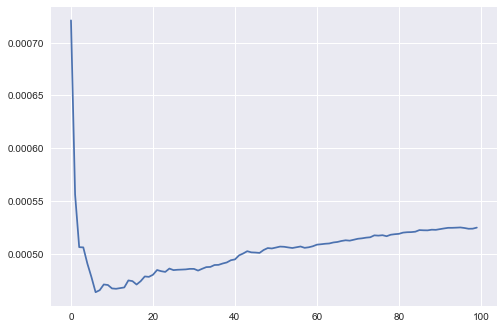

In [119]:
# For KNN, we don't do cross validation because KNN prediction is too time consumming ! 
# Indeed, cross validation imply all of the data will be predicted
# Thus, we train on all of the data except 1k observartions, and predict on these 1k observations
error = []
knr_val = random.sample(range(n), 1000) 
knr_train = [i for i in range(n) if i not in knr_val]

t = time.time()
for k in range(1,101):
    clf_neigh = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    clf_neigh.fit(x_train.iloc[knr_train], y_train.iloc[knr_train])
    error.append(MSE(y_train[knr_val] ,clf_neigh.predict(x_train.iloc[knr_val])))
print((time.time()-t)/60, "min")
plt.plot(error)
plt.show()

209.2106625000636 min


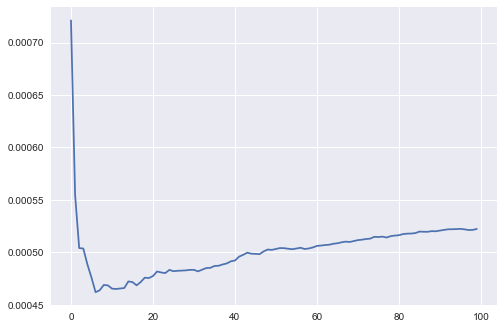

In [120]:
error = []
t = time.time()
for k in range(1,101):
    clf_neigh = KNeighborsRegressor(n_neighbors=k, weights='distance')
    clf_neigh.fit(x_train.iloc[knr_train], y_train.iloc[knr_train])
    error.append(MSE(y_train[knr_val] ,clf_neigh.predict(x_train.iloc[knr_val])))
print((time.time()-t)/60, "min")
plt.plot(error)
plt.show()

We run the top KNN algorithm (k=5, weights=distance) and plot the error estimation (only on the 1000 test observation) :

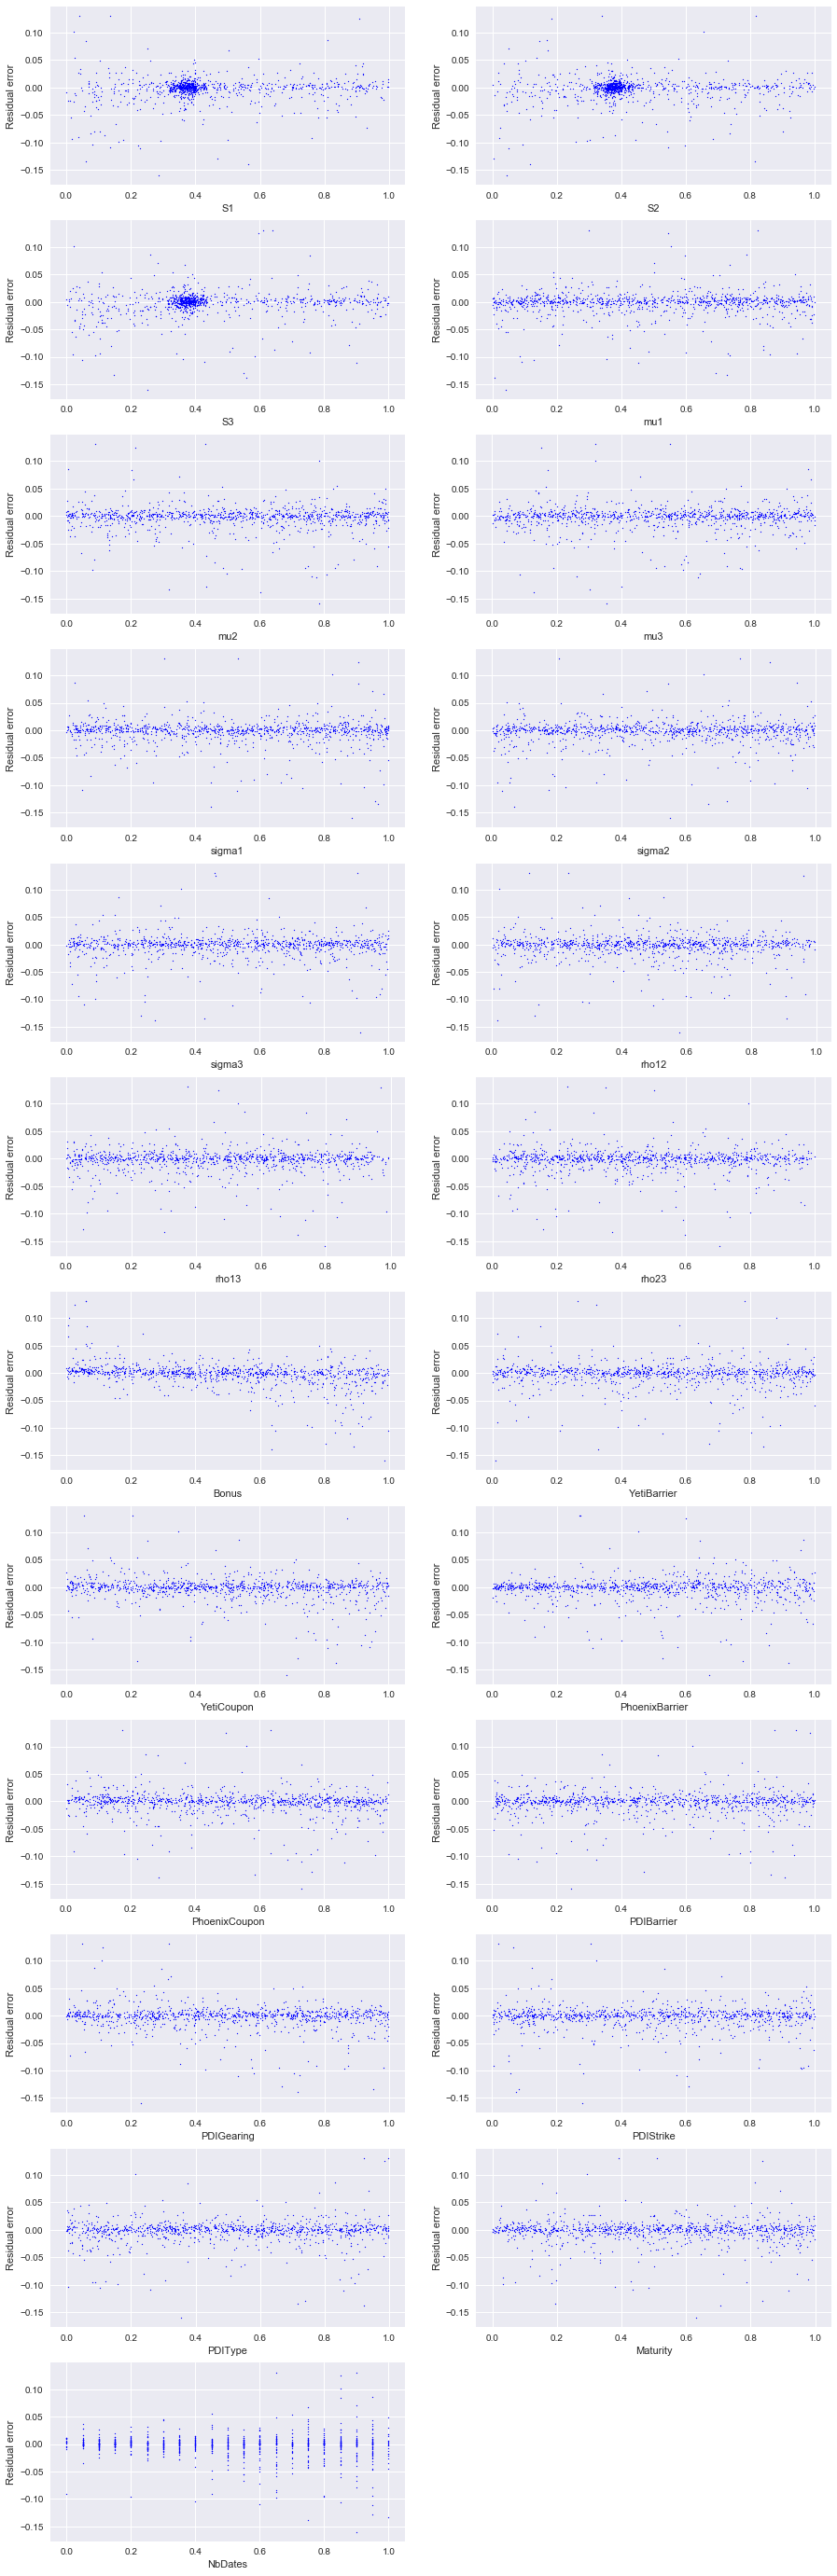

1.8049916823705037 min


In [44]:
t = time.time()
clf_neigh = KNeighborsRegressor(n_neighbors=5, weights='distance')
clf_neigh.fit(x_train.iloc[knr_train], y_train.iloc[knr_train])
plot_residual_error(clf_neigh, x_train.iloc[knr_val], y_train.iloc[knr_val])
print((time.time()-t)/60, "min")

Random forest : use bootstrap on the initial sample. Train random forest on this bootstrap sample (it choose random features at each nodes). Reapet it 10 times. Finally, take the average prediction of the 10 trees. Advantages of bootstrap : correlation of each trees decreases using randomness while selecting the sample. Randomness while selecting a portin of features also decrese their correlation. As a consequence, by taking the average of the trees, the variance decrease. Indeed : $Var(\frac{1}{B} \sum tree_i)=\frac{1}{B}Var(tree)$ when the trees are independant (not really true here).

129.56346531311672 min


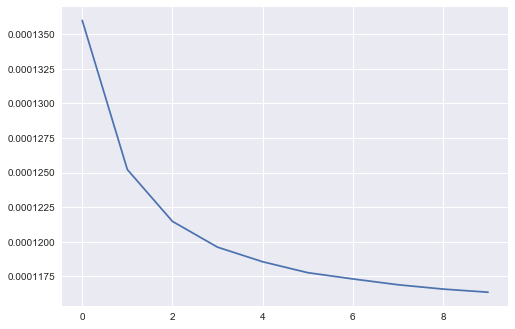

In [121]:
error = []
t = time.time()
for i in [10,20,30,40,50,60,70,80,90,100]:
    clf_rand_tree = RandomForestRegressor(n_estimators=i, max_depth=None, min_samples_split=2, random_state=0, n_jobs=-1)
    error.append(MSE_cross_val(x_train, y_train, clf_rand_tree)[0])
print((time.time()-t)/60, "min")
plt.plot(error)
plt.show()

We now look at the rank of the features according to their importance using random tree reggressor : a feature that has decreased a lot the loss function will have higher importance. 

In [122]:
feature_importance(x_train, clf_rand_tree)

[('Bonus', 0.3542512225067547),
 ('YetiCoupon', 0.0971298797102803),
 ('S3', 0.08962947079839204),
 ('NbDates', 0.08936776724952121),
 ('S2', 0.08254103643407605),
 ('S1', 0.07640049826930251),
 ('PhoenixBarrier', 0.06259119361328502),
 ('PDIGearing', 0.047918903262075686),
 ('PDIType', 0.02021610598700452),
 ('PDIBarrier', 0.015981723742207705),
 ('Maturity', 0.0122629832251137),
 ('PDIStrike', 0.00861712117624159),
 ('sigma2', 0.004558800267103909),
 ('PhoenixCoupon', 0.0044862263754992075),
 ('sigma1', 0.004485625786179899),
 ('sigma3', 0.0044839700005513735),
 ('YetiBarrier', 0.004050899448704131),
 ('rho23', 0.003586401499229424),
 ('mu1', 0.0035429040222098767),
 ('rho12', 0.003502241869565674),
 ('mu2', 0.0035017907783581087),
 ('rho13', 0.0034950214869816803),
 ('mu3', 0.003398212491361753)]

Extra tree : like random tree but we do not use bootstrap method at the begining while selecting our sample for a tree : we still considere the average of our 10 trees at the end but the trees are trained with the same sample (this increase the correlation of our tree). However, in addition of selecting a portion of the total features, we also randomly select the best split for each of the features (that has been randomly selected) using a uniforme law in [min(feature), max(feature)]. Then we choose the best feature decreasing the loss function. This double randomness allow to reduce a lot the correlation of our trees and then the variance (but the biais can be higher)

40.06018968423208 min


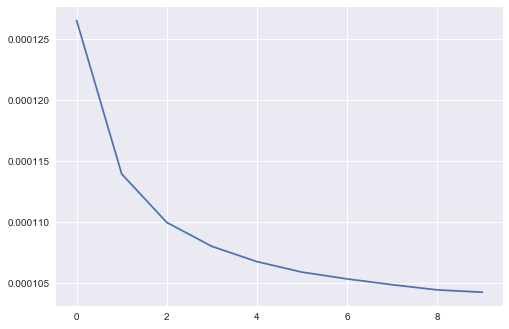

In [123]:
error = []
t = time.time()
for i in [10,20,30,40,50,60,70,80,90,100]:
    clf_extra_tree = ExtraTreesRegressor(n_estimators=i, max_depth=None, min_samples_split=2, random_state=0, n_jobs=-1)
    error.append(MSE_cross_val(x_train, y_train, clf_extra_tree)[0])
print((time.time()-t)/60, "min")
plt.plot(error)
plt.show()

In [124]:
feature_importance(x_train, clf_extra_tree)

[('Bonus', 0.34303345669637453),
 ('S3', 0.09197749888025541),
 ('S2', 0.08960757960030508),
 ('S1', 0.08921072213425553),
 ('YetiCoupon', 0.08715420747088666),
 ('NbDates', 0.08691211832293776),
 ('PhoenixBarrier', 0.06240263900414007),
 ('PDIGearing', 0.04334800851109079),
 ('PDIType', 0.01661675189352262),
 ('PDIBarrier', 0.01444024270727159),
 ('Maturity', 0.012627257758278087),
 ('PDIStrike', 0.008661475356267151),
 ('sigma3', 0.005434148811233799),
 ('PhoenixCoupon', 0.005432268746708837),
 ('sigma2', 0.0054220961835992135),
 ('sigma1', 0.005394399618167844),
 ('YetiBarrier', 0.0049974636658386175),
 ('rho23', 0.004646919524631631),
 ('rho13', 0.004586135748068114),
 ('rho12', 0.004572440848103276),
 ('mu1', 0.00456364624402662),
 ('mu3', 0.004498922812502143),
 ('mu2', 0.004459599461534808)]

We run the top extratree algorithm (with 150 estimator) and plot the error estimation :

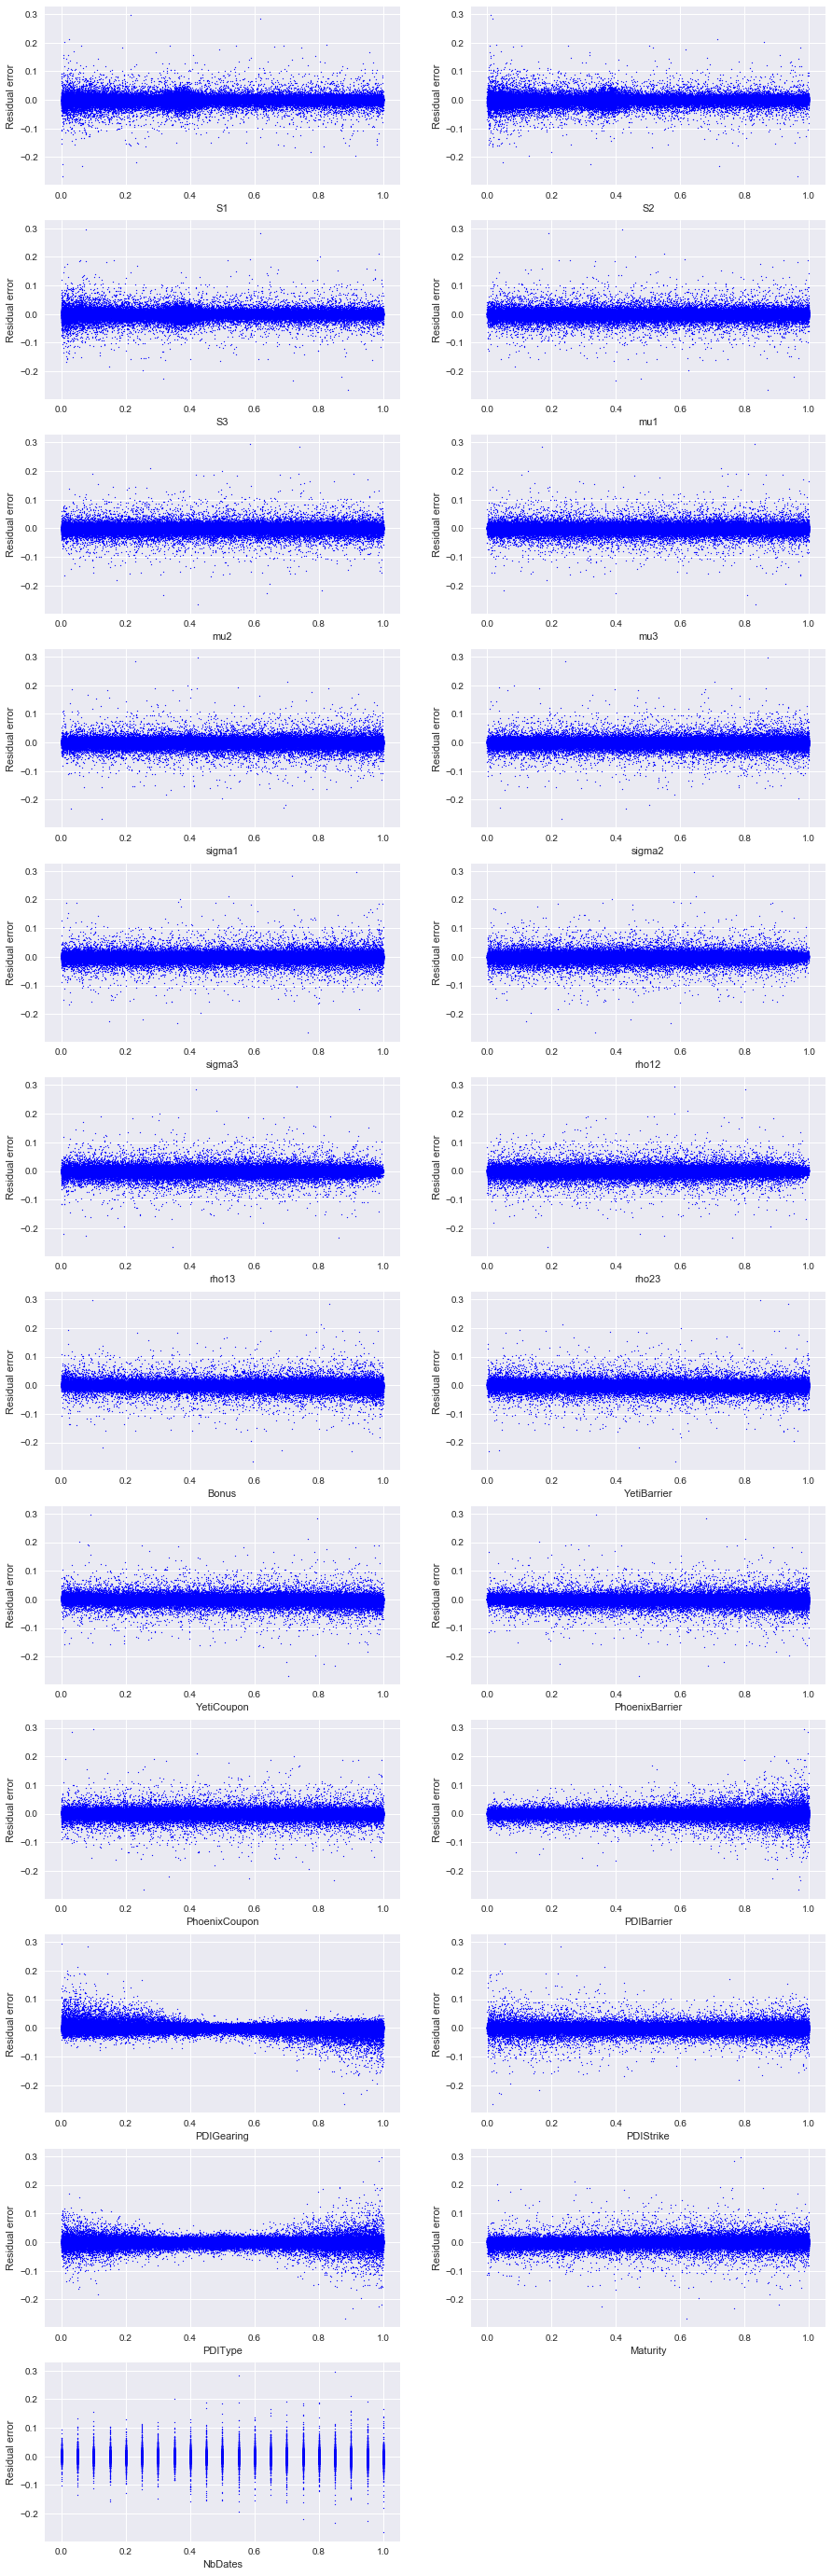

5.045136483510335 min


In [45]:
t = time.time()
clf_extra_tree = ExtraTreesRegressor(n_estimators=150, max_depth=None, min_samples_split=2, random_state=0, n_jobs=-1)
x_train_plot, x_val_plot, y_train_plot, y_val_plot = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
clf_extra_tree.fit(x_train_plot, y_train_plot)
plot_residual_error(clf_extra_tree, x_val_plot, y_val_plot)
print((time.time()-t)/60, "min")

Since the importance feature of the random forest and extra tree algorithm are almost the same, we are going to use the extra tree algorithm to rank new features that we are going to create. 

In [7]:
x_train_add = x_train.copy()

# sigma * racine(T)
x_train_add["vol_sq_t_1"] = x_train_add["sigma1"] * np.sqrt(x_train_add["Maturity"])
x_train_add["vol_sq_t_2"] = x_train_add["sigma2"] * np.sqrt(x_train_add["Maturity"])
x_train_add["vol_sq_t_3"] = x_train_add["sigma3"] * np.sqrt(x_train_add["Maturity"])

# sigma^2 
x_train_add["var_1"] = x_train_add["sigma1"] ** 2 
x_train_add["var_2"] = x_train_add["sigma2"] ** 2
x_train_add["var_3"] = x_train_add["sigma3"] ** 2

# s_i / s_j
x_train_add["S1/S2"] = x_train_add["S1"] / (x_train_add["S2"] + 0.01) # avoid dividing by zero
x_train_add["S1/S3"] = x_train_add["S1"] / (x_train_add["S3"] + 0.01)
x_train_add["S2/S3"] = x_train_add["S2"] / (x_train_add["S3"] + 0.01)

# barrier_i / barrier_j
x_train_add["YetiBarrier/PhoenixBarrier"] = x_train_add["YetiBarrier"] / (x_train_add["PhoenixBarrier"] + 0.01)
x_train_add["YetiBarrier/PDIBarrier"] = x_train_add["YetiBarrier"] / (x_train_add["PDIBarrier"] + 0.01)
x_train_add["PhoenixBarrier/PDIBarrier"] = x_train_add["PhoenixBarrier"] / (x_train_add["PDIBarrier"] + 0.01)

# we renormalize the data in [0,1]
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(x_train_add)
x_train_add.loc[:] = df_scaled

Does our features engineering provide interesting meaning for accuracy ?
- We can see that looking a the propotion of the spot price at t=0 seems to be a good idea. This is due to the fact that coupon are paid at each time $t_i$ according to the value of the worst spot price between S1 S2 and S3. 
- We add $\sqrt T\sigma$ since this factor often appears in analytic formula for options, but it does not have much impact.
- Proportion of the barrier is less impacting.

In [30]:
t = time.time()
clf_extra_tree = ExtraTreesRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0, n_jobs=-1)
print(MSE_cross_val(x_train_add, y_train, clf_extra_tree)[0])
print((time.time()-t)/60, "min")
print(feature_importance(x_train_add, clf_extra_tree))

0.00010485429176283757
10.685141019026439 min
[('Bonus', 0.34303203711456626), ('NbDates', 0.09088191055491615), ('YetiCoupon', 0.08689329212339926), ('S3', 0.07253084688476152), ('S2', 0.07052186243461435), ('S1', 0.07047925894560575), ('PhoenixBarrier', 0.059578607496298605), ('PDIGearing', 0.04177238553979365), ('S1/S2', 0.01914075332891006), ('S2/S3', 0.018124095368151093), ('S1/S3', 0.01781905373678942), ('PDIType', 0.013784676993570668), ('PDIBarrier', 0.01193500191434068), ('Maturity', 0.008539570467367804), ('PDIStrike', 0.006546472358706311), ('vol_sq_t_2', 0.005295941121557171), ('vol_sq_t_3', 0.0052653549373806565), ('vol_sq_t_1', 0.005195348485763041), ('PhoenixCoupon', 0.004036236123580934), ('YetiBarrier/PhoenixBarrier', 0.0033858329597078684), ('rho23', 0.0033168652857573176), ('rho13', 0.0033013062028347515), ('mu1', 0.003269585814846365), ('rho12', 0.0032694092342685655), ('YetiBarrier', 0.003253411986290132), ('mu2', 0.0031814620851541536), ('mu3', 0.00317864713576306

Adaboost : begin with a weak regressor (here decision tree which is different from random tree or extra tree). Then improve this regressor by considering new weeks regressors. At the end, average these week regressor accoridng to their overall performance. At each step when adding a new regressor, we change the importance of the observation that has been mispredicted at the previous step by adding more importante weight. 

We run 3 different Adaboost algorithm using 3 different losses : 'linear', 'square', 'exponential'

192.64223429759343 min , learning rate : 0.001


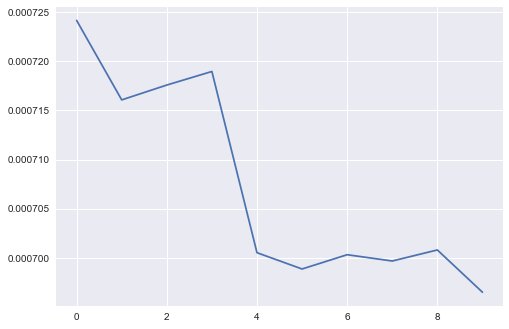

192.75945981740952 min , learning rate : 0.01


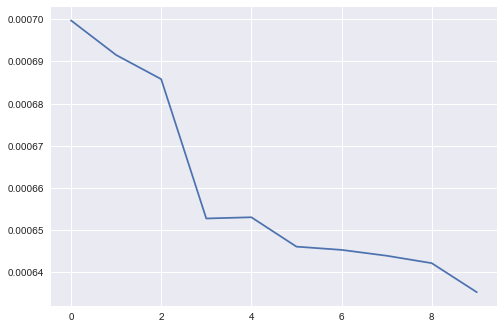

181.58537586927415 min , learning rate : 0.1


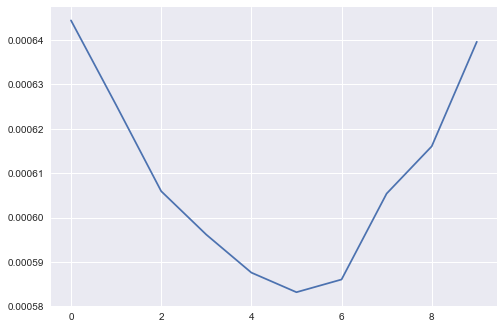

108.7430687824885 min , learning rate : 1


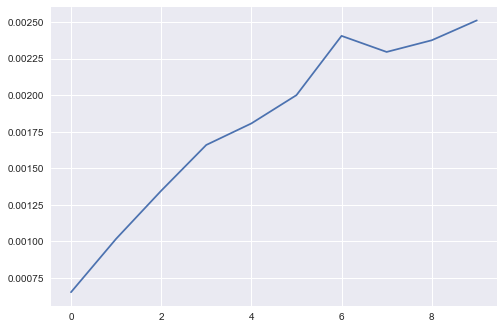

In [11]:
for lr in [0.001, 0.01, 0.1, 1]:
    error = []
    t = time.time()
    for i in [10,20,30,40,50,60,70,80,90,100]:
        clf_ada1 = AdaBoostRegressor(n_estimators=i, learning_rate=lr)
        error.append(MSE_cross_val(x_train, y_train, clf_ada1)[0])
    print((time.time()-t)/60, "min", ", learning rate :", lr)
    plt.plot(error)
    plt.show()

Try other loss function that update the weights importance of the samples :

192.79562406539918 min , learning rate : 0.001


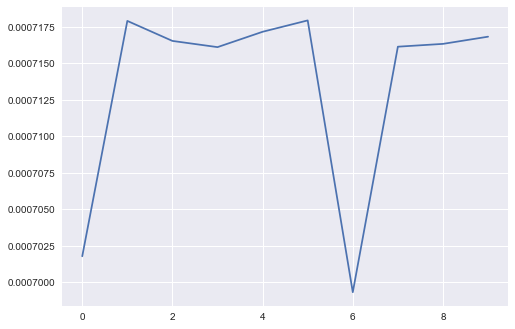

193.09546234607697 min , learning rate : 0.01


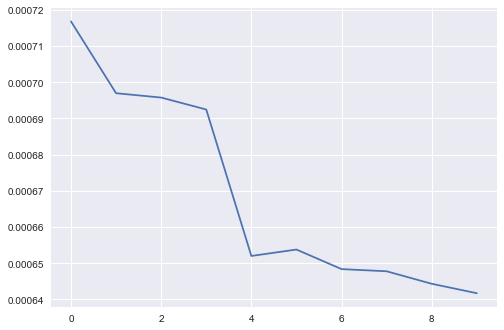

181.1430046359698 min , learning rate : 0.1


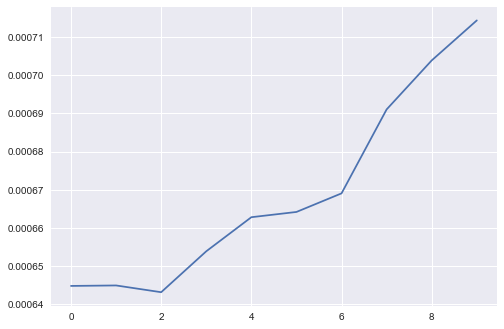

90.99215000073114 min , learning rate : 1


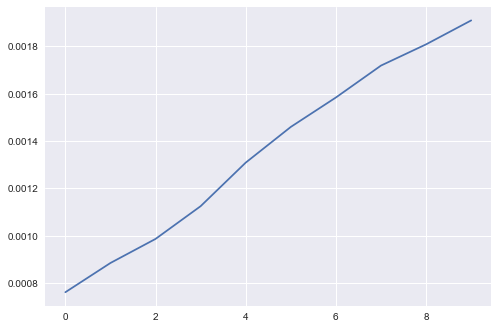

In [45]:
for lr in [0.001, 0.01, 0.1, 1]:
    error = []
    t = time.time()
    for i in [10,20,30,40,50,60,70,80,90,100]:
        clf_ada2 = AdaBoostRegressor(n_estimators=i, learning_rate=lr, loss='square')
        error.append(MSE_cross_val(x_train, y_train, clf_ada2)[0])
    print((time.time()-t)/60, "min", ", learning rate :", lr)
    plt.plot(error)
    plt.show()

210.4539170026779 min , learning rate : 0.001


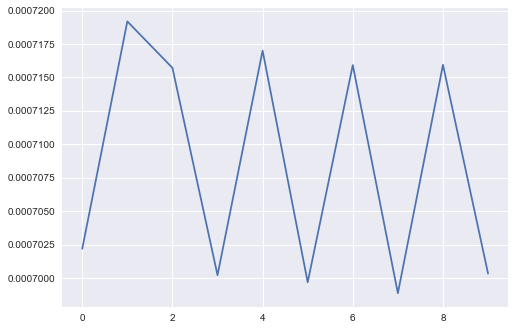

195.62877934773763 min , learning rate : 0.01


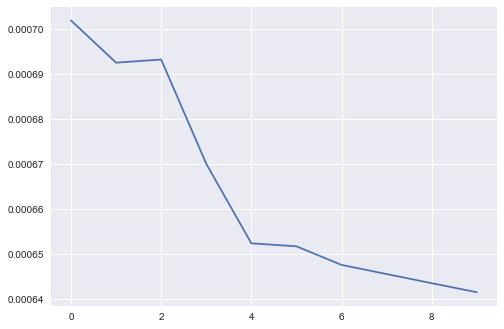

184.50672486623128 min , learning rate : 0.1


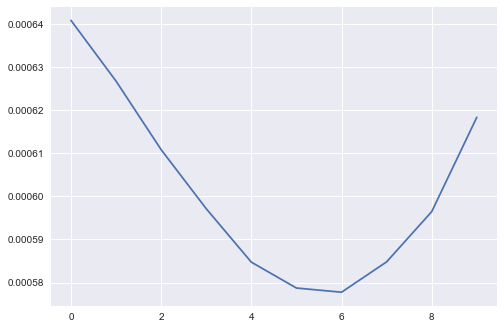

116.194482533137 min , learning rate : 1


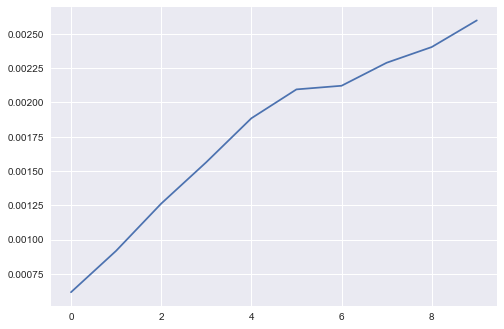

In [46]:
for lr in [0.001, 0.01, 0.1, 1]:
    error = []
    t = time.time()
    for i in [10,20,30,40,50,60,70,80,90,100]:
        clf_ada3 = AdaBoostRegressor(n_estimators=i, learning_rate=lr, loss='exponential')
        error.append(MSE_cross_val(x_train, y_train, clf_ada3)[0])
    print((time.time()-t)/60, "min", ", learning rate :", lr)
    plt.plot(error)
    plt.show()

We run the top Adaboost algorithm (70 estimators, exponential loss and 0.1 learning rate) and plot the error estimation :

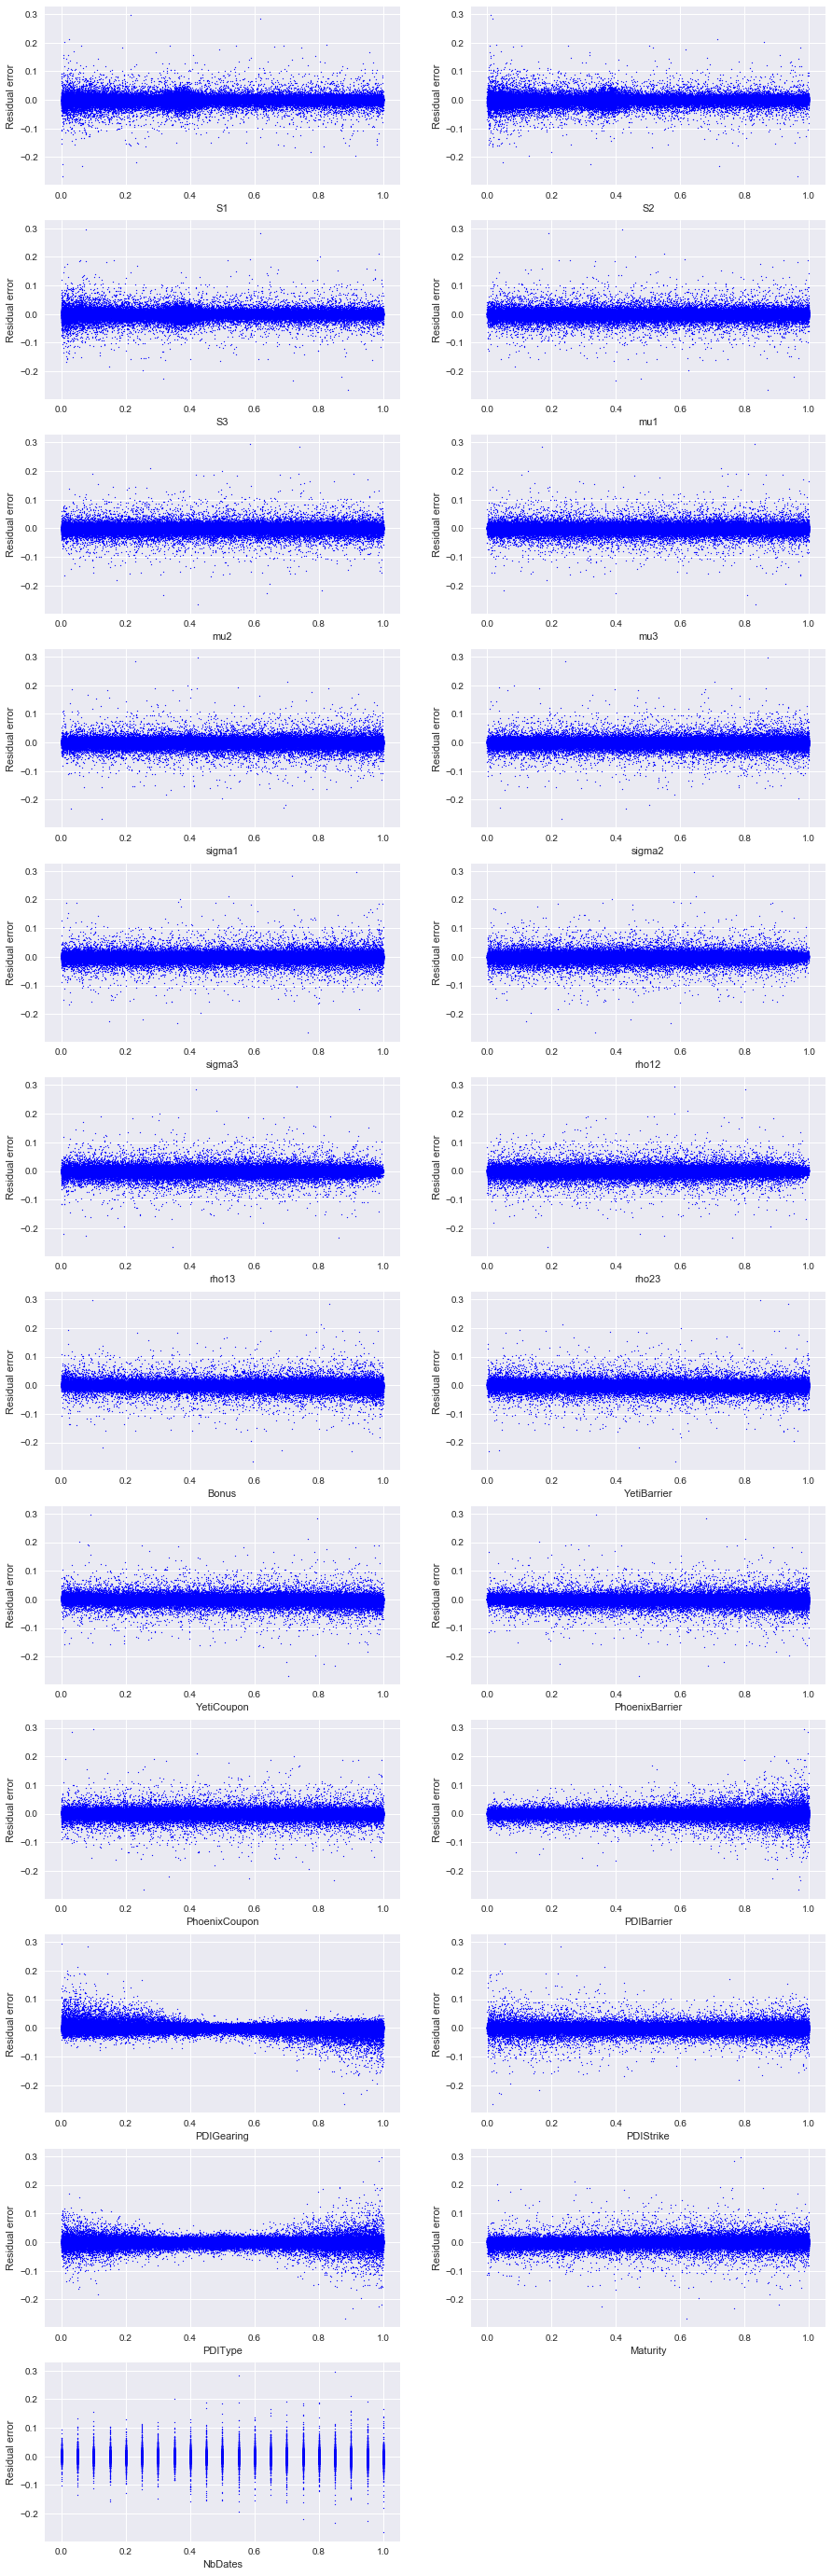

10.743040200074514 min


In [46]:
t = time.time()
clf_ada3 = AdaBoostRegressor(n_estimators=70, learning_rate=0.1, loss='exponential')
clf_ada3.fit(x_train_plot, y_train_plot)
plot_residual_error(clf_extra_tree, x_val_plot, y_val_plot)
print((time.time()-t)/60, "min")

## Neural network

We have first build different neural network with cross validation. The best architecture among our different test has been defined in the function my_nn. Adding a relu activation at the last layer and adding dropout has been definitely a bad choice.

In [8]:
def send_imessage(message, name):
    """
    Function to send myself an imessage (when a model finished)
    """
    
    cmd = '''osascript<<END
    tell application "Messages"
    send '''+''' "'''+message+'''" '''+''' to buddy'''+''' "'''+name+'''" '''+'''
    end tell
    END'''
    os.system(cmd)

def flat_list(x):
    """
    Transform a list of list to a list (this is used for the prediction of Keras)
    """
    return list(itertools.chain(*x))

def MSE_nn_cross_val(x_train, y_train, fct_nn, optimizer='adam', epochs=250):
    """
    Compute the MSE of a neural network using cross validation 
    
    fct_nn : neural network model (Dense)
    return : - the average MSE on the test folds
             - the model
    """
    compute_MSE = []
    val_loss = []
    
    for train_index, val_index in kf.split(x_train, y_train):  
        
        x = x_train.iloc[train_index]
        y = y_train[train_index]
        model = fct_nn(len(x_train.columns))
        model.compile(loss='MSE', optimizer=optimizer)
        hist = model.fit(x, y, epochs=epochs, validation_data=(x_train.iloc[val_index], y_train[val_index]))
        compute_MSE.append(MSE(y_train[val_index], flat_list(model.predict(x_train.iloc[val_index]))))
        val_loss.append(hist.history['val_loss'])
        #send_imessage(str(val_loss[-1][0]), 'John Sibony')
        
    val_loss = pd.DataFrame(val_loss)
    val_loss = list(val_loss.mean(axis=0))
    
    plt.plot(val_loss)
    plt.legend(["cross_val_loss"], loc="upper right")
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.show()
    return np.mean(compute_MSE), model

In [9]:
def my_nn(input_dim):
    """
    Neural network with 8 hidden layers, relu/sigmoid activations
    """
    model = Sequential()
    model.add(Dense(500, input_dim=input_dim, activation='relu'))
    model.add(Dense(400, activation='sigmoid'))
    model.add(Dense(300, activation='relu'))
    model.add(Dense(250, activation='sigmoid'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

Train on 500000 samples, validate on 500000 samples
Epoch 1/250
500000/500000 [==============================] - 137s 273us/step - loss: 1.4755e-04 - val_loss: 3.5207e-05
Epoch 2/250
500000/500000 [==============================] - 121s 242us/step - loss: 3.4122e-05 - val_loss: 2.8185e-05
Epoch 3/250
500000/500000 [==============================] - 104s 207us/step - loss: 2.3542e-05 - val_loss: 1.9652e-05
Epoch 4/250
500000/500000 [==============================] - 128s 256us/step - loss: 1.8251e-05 - val_loss: 1.2837e-05
Epoch 5/250
500000/500000 [==============================] - 99s 199us/step - loss: 1.5277e-05 - val_loss: 1.1201e-05
Epoch 6/250
500000/500000 [==============================] - 100s 200us/step - loss: 1.3127e-05 - val_loss: 9.6967e-06
Epoch 7/250
500000/500000 [==============================] - 98s 195us/step - loss: 1.1545e-05 - val_loss: 1.0490e-05
Epoch 8/250
500000/500000 [==============================] - 102s 203us/step - loss: 1.0527e-05 - val_loss: 1.4200e-0

500000/500000 [==============================] - 99s 199us/step - loss: 1.7745e-06 - val_loss: 1.8163e-06
Epoch 138/250
500000/500000 [==============================] - 98s 196us/step - loss: 1.7301e-06 - val_loss: 2.0174e-06
Epoch 139/250
500000/500000 [==============================] - 99s 197us/step - loss: 1.7593e-06 - val_loss: 1.8174e-06
Epoch 140/250
500000/500000 [==============================] - 99s 198us/step - loss: 1.7892e-06 - val_loss: 1.7592e-06
Epoch 141/250
500000/500000 [==============================] - 95s 190us/step - loss: 1.6905e-06 - val_loss: 2.0795e-06
Epoch 142/250
500000/500000 [==============================] - 98s 195us/step - loss: 1.7076e-06 - val_loss: 1.8270e-06
Epoch 143/250
500000/500000 [==============================] - 99s 197us/step - loss: 1.6734e-06 - val_loss: 1.8353e-06
Epoch 144/250
500000/500000 [==============================] - 97s 194us/step - loss: 1.6960e-06 - val_loss: 1.9133e-06
Epoch 145/250
500000/500000 [=========================

500000/500000 [==============================] - 97s 195us/step - loss: 5.1349e-06 - val_loss: 4.5205e-06
Epoch 24/250
500000/500000 [==============================] - 99s 198us/step - loss: 4.9468e-06 - val_loss: 4.5518e-06
Epoch 25/250
500000/500000 [==============================] - 97s 194us/step - loss: 4.8194e-06 - val_loss: 4.6728e-06
Epoch 26/250
500000/500000 [==============================] - 97s 194us/step - loss: 4.7824e-06 - val_loss: 5.2751e-06
Epoch 27/250
500000/500000 [==============================] - 99s 197us/step - loss: 4.5249e-06 - val_loss: 4.5116e-06
Epoch 28/250
500000/500000 [==============================] - 97s 194us/step - loss: 4.4831e-06 - val_loss: 5.2003e-06
Epoch 29/250
500000/500000 [==============================] - 96s 193us/step - loss: 4.3049e-06 - val_loss: 4.2277e-06
Epoch 30/250
500000/500000 [==============================] - 99s 198us/step - loss: 4.3123e-06 - val_loss: 4.4996e-06
Epoch 31/250
500000/500000 [==============================] -

Epoch 92/250
500000/500000 [==============================] - 97s 194us/step - loss: 2.2009e-06 - val_loss: 3.4350e-06
Epoch 93/250
500000/500000 [==============================] - 97s 195us/step - loss: 2.0854e-06 - val_loss: 2.4389e-06
Epoch 94/250
500000/500000 [==============================] - 99s 198us/step - loss: 2.1549e-06 - val_loss: 2.3481e-06
Epoch 95/250
500000/500000 [==============================] - 98s 196us/step - loss: 2.2086e-06 - val_loss: 2.1860e-06
Epoch 96/250
500000/500000 [==============================] - 98s 196us/step - loss: 2.0723e-06 - val_loss: 2.5368e-06
Epoch 97/250
500000/500000 [==============================] - 98s 195us/step - loss: 2.1538e-06 - val_loss: 2.3459e-06
Epoch 98/250
500000/500000 [==============================] - 99s 197us/step - loss: 2.1030e-06 - val_loss: 2.8023e-06
Epoch 99/250
500000/500000 [==============================] - 98s 196us/step - loss: 2.0717e-06 - val_loss: 3.2849e-06
Epoch 100/250
500000/500000 [===================

500000/500000 [==============================] - 97s 195us/step - loss: 1.2341e-06 - val_loss: 1.5683e-06
Epoch 229/250
500000/500000 [==============================] - 99s 198us/step - loss: 1.2856e-06 - val_loss: 1.5559e-06
Epoch 230/250
500000/500000 [==============================] - 98s 196us/step - loss: 1.2815e-06 - val_loss: 1.7700e-06
Epoch 231/250
500000/500000 [==============================] - 99s 197us/step - loss: 1.2543e-06 - val_loss: 1.6451e-06
Epoch 232/250
500000/500000 [==============================] - 99s 198us/step - loss: 1.2673e-06 - val_loss: 1.6212e-06
Epoch 233/250
500000/500000 [==============================] - 99s 199us/step - loss: 1.2615e-06 - val_loss: 1.8692e-06
Epoch 234/250
500000/500000 [==============================] - 98s 197us/step - loss: 1.2594e-06 - val_loss: 1.6067e-06
Epoch 235/250
500000/500000 [==============================] - 98s 196us/step - loss: 1.2183e-06 - val_loss: 1.9763e-06
Epoch 236/250
500000/500000 [=========================

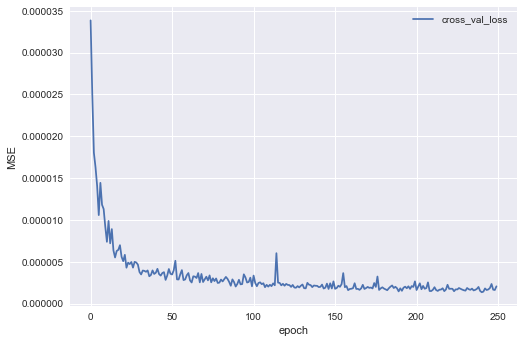

821.209808532397 min


In [34]:
t = time.time()
score, model = MSE_nn_cross_val(x_poly, y_train, my_nn)
print((time.time()-t)/60, "min")

#### 1) Looking for best NN features

We first construct a basic NN with 4 layers. We reduce the number of neurons compared to the previous NN benchmark. We also take only 50 epochs (no more improvement after, see just above)

In [10]:
def first_nn(input_dim):
    """
    Neural network with 4 hidden layers, relu/sigmoid activations
    """
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim, activation='relu'))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

Since NN are very time consuming, instead of doing cross validation we only train the NN for 50% of the data and predict on the remaining 50% : 

In [48]:
x_nn_train, x_nn_val, y_nn_train, y_nn_val = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

Train on 500000 samples, validate on 500000 samples
Epoch 1/50
500000/500000 [==============================] - 28s 56us/step - loss: 3.3876e-04 - val_loss: 1.6170e-04
Epoch 2/50
500000/500000 [==============================] - 26s 53us/step - loss: 1.2965e-04 - val_loss: 1.0199e-04
Epoch 3/50
500000/500000 [==============================] - 26s 52us/step - loss: 9.1352e-05 - val_loss: 8.5631e-05
Epoch 4/50
500000/500000 [==============================] - 26s 52us/step - loss: 7.5914e-05 - val_loss: 6.9241e-05
Epoch 5/50
500000/500000 [==============================] - 26s 53us/step - loss: 6.6014e-05 - val_loss: 6.8230e-05
Epoch 6/50
500000/500000 [==============================] - 26s 53us/step - loss: 5.9854e-05 - val_loss: 5.6849e-05
Epoch 7/50
500000/500000 [==============================] - 26s 53us/step - loss: 5.4970e-05 - val_loss: 5.1126e-05
Epoch 8/50
500000/500000 [==============================] - 26s 53us/step - loss: 5.1408e-05 - val_loss: 4.9814e-05
Epoch 9/50
500000/50

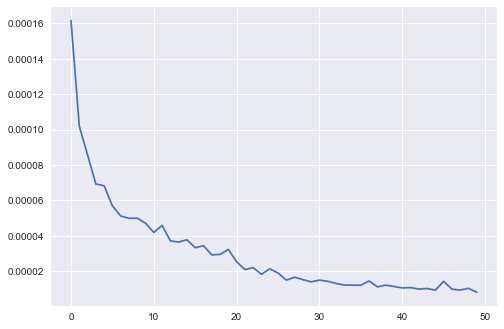

21.981021265188854 min


In [49]:
t = time.time()

f = first_nn(len(x_nn_train.columns))
f.compile(loss='MSE', optimizer='adamax')
model = f.fit(x_nn_train, y_nn_train, epochs=50, validation_data=(x_nn_val, y_nn_val))
plt.plot(model.history['val_loss'])
plt.show()

print((time.time()-t)/60, "min")

We do feature engineering, the same as earlier with the extra tree regressor (see above)

In [50]:
x_nn_add_train, x_nn_add_val, y_nn_add_train, y_nn_add_val = train_test_split(x_train_add, y_train, test_size=0.5, random_state=42)

Train on 500000 samples, validate on 500000 samples
Epoch 1/50
500000/500000 [==============================] - 28s 56us/step - loss: 2.9432e-04 - val_loss: 1.5788e-04
Epoch 2/50
500000/500000 [==============================] - 28s 55us/step - loss: 1.1970e-04 - val_loss: 1.1422e-04
Epoch 3/50
500000/500000 [==============================] - 27s 55us/step - loss: 8.0179e-05 - val_loss: 7.0383e-05
Epoch 4/50
500000/500000 [==============================] - 27s 54us/step - loss: 6.0137e-05 - val_loss: 5.3855e-05
Epoch 5/50
500000/500000 [==============================] - 27s 54us/step - loss: 4.6527e-05 - val_loss: 4.0923e-05
Epoch 6/50
500000/500000 [==============================] - 27s 54us/step - loss: 3.9164e-05 - val_loss: 3.6252e-05
Epoch 7/50
500000/500000 [==============================] - 27s 54us/step - loss: 3.4323e-05 - val_loss: 3.5397e-05
Epoch 8/50
500000/500000 [==============================] - 27s 54us/step - loss: 3.0657e-05 - val_loss: 3.3380e-05
Epoch 9/50
500000/50

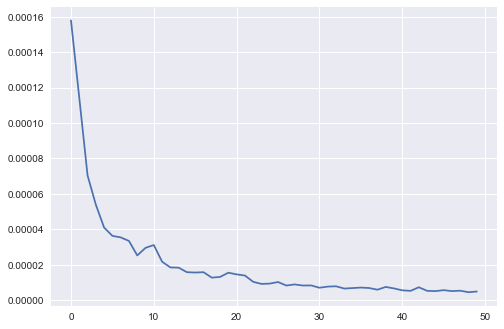

22.42200408379237 min


In [51]:
t = time.time()

f = first_nn(len(x_nn_add_train.columns))
f.compile(loss='MSE', optimizer='adamax')
model = f.fit(x_nn_add_train, y_nn_add_train, epochs=50, validation_data=(x_nn_add_val, y_nn_add_val))
plt.plot(model.history['val_loss'])
plt.show()

print((time.time()-t)/60, "min")

We do another kind of features engineering by creating interactions features for the NN :

In [52]:
interac = PolynomialFeatures(interaction_only=True)
x_interac = interac.fit_transform(x_train)
x_interac = pd.DataFrame(x_interac)
name_columns = interac.get_feature_names(x_train.columns)
name_columns[0] = "intercept"
x_interac.columns = name_columns

In [53]:
x_nn_interac_train, x_nn_interac_val, y_nn_interac_train, y_nn_interac_val = train_test_split(x_interac, y_train, test_size=0.5, random_state=42)

Train on 500000 samples, validate on 500000 samples
Epoch 1/50
500000/500000 [==============================] - 45s 89us/step - loss: 2.4227e-04 - val_loss: 8.5258e-05
Epoch 2/50
500000/500000 [==============================] - 30s 61us/step - loss: 6.2892e-05 - val_loss: 4.3225e-05
Epoch 3/50
500000/500000 [==============================] - 30s 61us/step - loss: 3.5258e-05 - val_loss: 4.1953e-05
Epoch 4/50
500000/500000 [==============================] - 30s 61us/step - loss: 2.3003e-05 - val_loss: 2.6779e-05
Epoch 5/50
500000/500000 [==============================] - 30s 61us/step - loss: 1.8345e-05 - val_loss: 1.7767e-05
Epoch 6/50
500000/500000 [==============================] - 30s 61us/step - loss: 1.5547e-05 - val_loss: 1.5265e-05
Epoch 7/50
500000/500000 [==============================] - 30s 61us/step - loss: 1.3796e-05 - val_loss: 1.6108e-05
Epoch 8/50
500000/500000 [==============================] - 31s 61us/step - loss: 1.2472e-05 - val_loss: 1.1646e-05
Epoch 9/50
500000/50

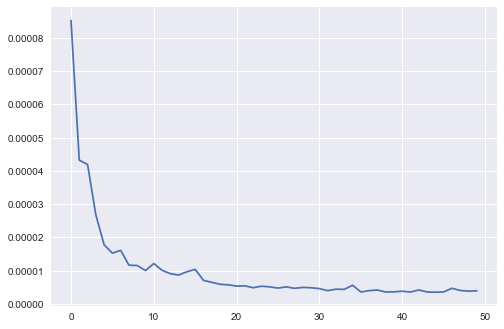

25.50884948174159 min


In [54]:
t = time.time()

f = first_nn(len(x_nn_interac_train.columns))
f.compile(loss='MSE', optimizer='adamax')
model = f.fit(x_nn_interac_train, y_nn_interac_train, epochs=50, validation_data=(x_nn_interac_val, y_nn_interac_val))
plt.plot(model.history['val_loss'])
plt.show()

print((time.time()-t)/60, "min")

We do another kind of features engineering by creating polynomial (with interaction) features for the NN :

In [11]:
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x_train)
x_poly = pd.DataFrame(x_poly)
name_columns = poly.get_feature_names(x_train.columns)
name_columns[0] = "intercept"
x_poly.columns = name_columns

In [12]:
x_nn_poly_train, x_nn_poly_val, y_nn_poly_train, y_nn_poly_val = train_test_split(x_poly, y_train, test_size=0.5, random_state=42)

Train on 500000 samples, validate on 500000 samples
Epoch 1/50
500000/500000 [==============================] - 39s 78us/step - loss: 1.5812e-04 - val_loss: 8.2662e-05
Epoch 2/50
500000/500000 [==============================] - 32s 64us/step - loss: 5.9471e-05 - val_loss: 5.3791e-05
Epoch 3/50
500000/500000 [==============================] - 31s 63us/step - loss: 3.5978e-05 - val_loss: 3.0405e-05
Epoch 4/50
500000/500000 [==============================] - 31s 62us/step - loss: 2.5418e-05 - val_loss: 1.9117e-05
Epoch 5/50
500000/500000 [==============================] - 31s 63us/step - loss: 1.9740e-05 - val_loss: 1.7761e-05
Epoch 6/50
500000/500000 [==============================] - 31s 63us/step - loss: 1.6388e-05 - val_loss: 1.6534e-05
Epoch 7/50
500000/500000 [==============================] - 31s 62us/step - loss: 1.4283e-05 - val_loss: 1.2321e-05
Epoch 8/50
500000/500000 [==============================] - 31s 62us/step - loss: 1.2743e-05 - val_loss: 1.2597e-05
Epoch 9/50
500000/50

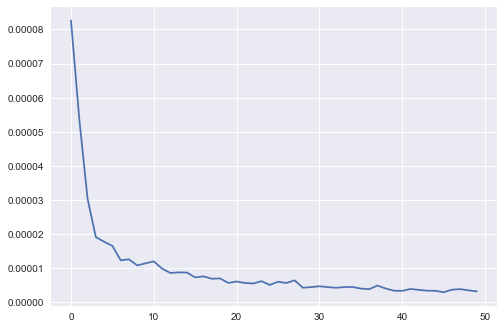

26.22848048210144 min


In [57]:
t = time.time()

f = first_nn(len(x_nn_poly_train.columns))
f.compile(loss='MSE', optimizer='adamax')
model = f.fit(x_nn_poly_train, y_nn_poly_train, epochs=50, validation_data=(x_nn_poly_val, y_nn_poly_val))
plt.plot(model.history['val_loss'])
plt.show()

print((time.time()-t)/60, "min")

Polynomial features with interaction increase our results. We will focus on it.

#### 2) Looking for best NN architecture

In [15]:
t = time.time()

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

for opt in optimizer:

    f = first_nn(len(x_nn_poly_train.columns))
    f.compile(loss='MSE', optimizer=opt)
    model = f.fit(x_nn_poly_train, y_nn_poly_train, epochs=50, validation_data=(x_nn_poly_val, y_nn_poly_val), verbose=0)
    print(opt, " : ", model.history['val_loss'][-1])
print("\n")
print((time.time()-t)/60, "min")

SGD  :  0.0003985631125350483
RMSprop  :  8.864041433891544e-06
Adagrad  :  1.8829145154057186e-05
Adadelta  :  3.074106754046807e-05
Adam  :  5.338295792884309e-06
Adamax  :  3.4376137558883783e-06
Nadam  :  1.0369609219043922e-05


150.09718995491664 min


We obtain the best result using Adamax optimizer. We now look at the learning rate :

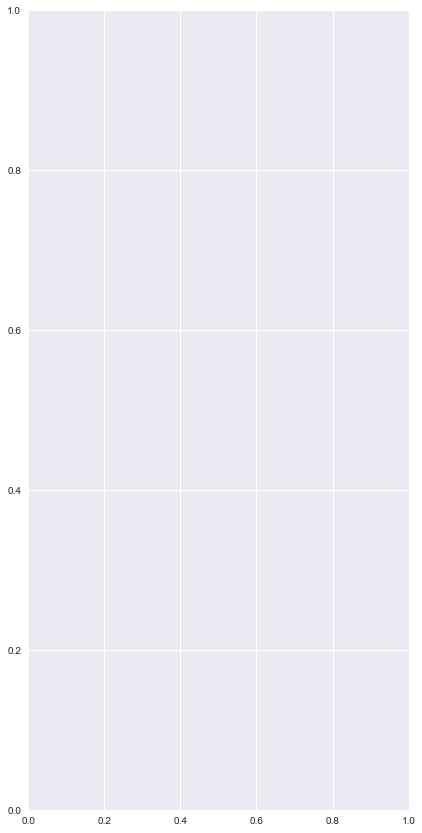

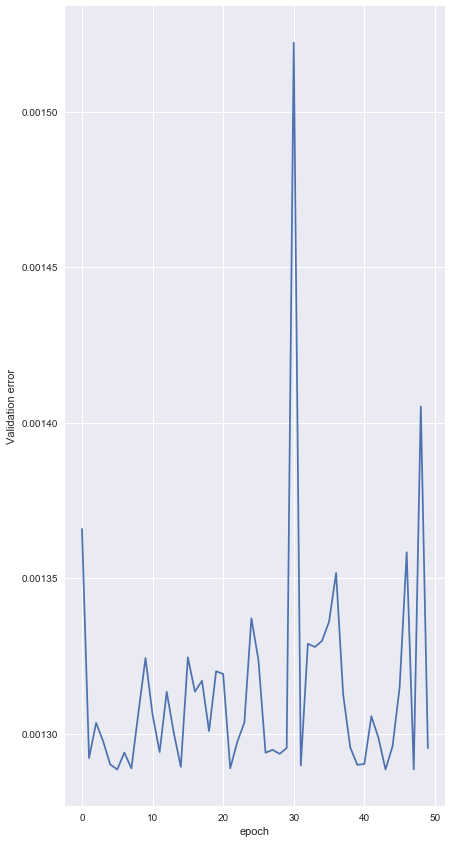

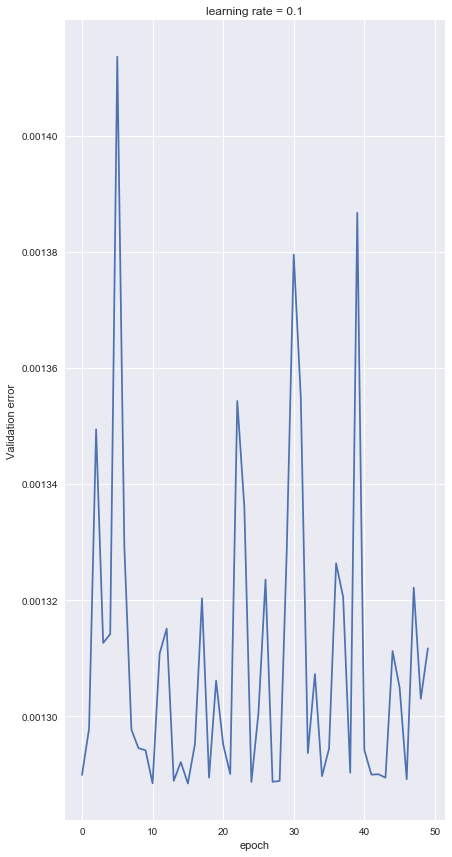

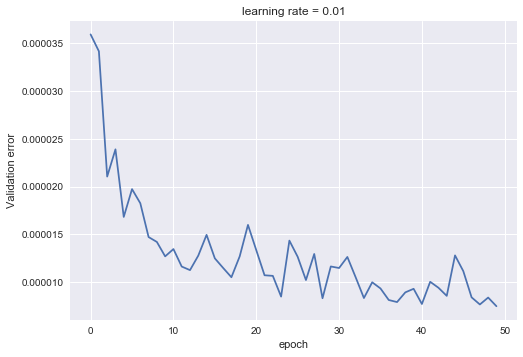

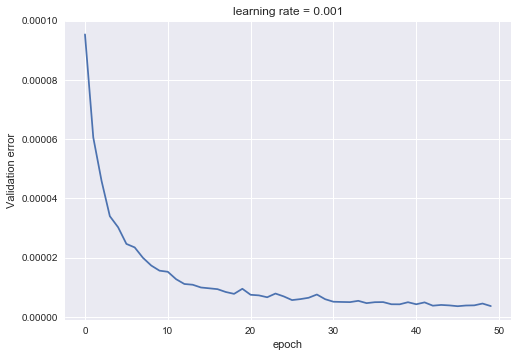

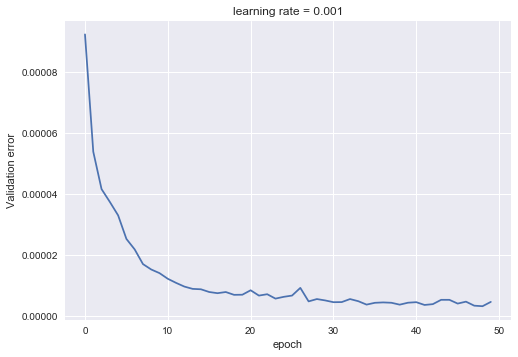

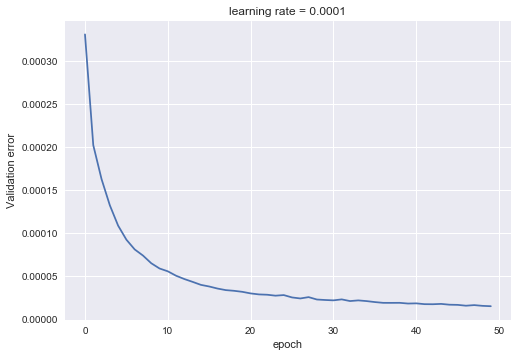



157.80320841471354 min


In [36]:
t = time.time()
fig = plt.figure(figsize=(15,50))

learning_rate = [0.1, 0.01, 0.001, 0.001 , 0.0001]

for index,lr in enumerate(learning_rate):
    fig.add_subplot(3, 2, index+1)
    f = first_nn(len(x_nn_poly_train.columns))
    opt = Adamax(lr=lr)
    f.compile(loss='MSE', optimizer=opt)
    model = f.fit(x_nn_poly_train, y_nn_poly_train, epochs=50, validation_data=(x_nn_poly_val, y_nn_poly_val), verbose=0)
    plt.plot(model.history['val_loss'])
    plt.xlabel("epoch")
    plt.ylabel("Validation error")
    plt.title('learning rate = '+str(lr))
    plt.show()
    
print("\n")
print((time.time()-t)/60, "min")

The default learning rate of Adamax (0.001) is the best, we keep it. We now look at the best weight initializer :

In [39]:
t = time.time()

init_mode = ['lecun_uniform', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

for i in init_mode:
    
    f = Sequential()
    f.add(Dense(100, input_dim=len(x_nn_poly_train.columns), activation='relu', kernel_initializer=i))
    f.add(Dense(50, activation='sigmoid', kernel_initializer=i))
    f.add(Dense(10, activation='relu', kernel_initializer=i))
    f.add(Dense(1, activation='sigmoid', kernel_initializer=i))
    f.compile(loss='MSE', optimizer='Adamax')
    model = f.fit(x_nn_poly_train, y_nn_poly_train, epochs=50, validation_data=(x_nn_poly_val, y_nn_poly_val), verbose=0)
    print(i, " : ", model.history['val_loss'][-1])
    
print("\n")
print((time.time()-t)/60, "min")

lecun_uniform  :  2.494305223766787e-06
glorot_normal  :  3.050314499725573e-06
glorot_uniform  :  3.6031365599174023e-06
he_normal  :  2.7680738989074596e-06
he_uniform  :  3.423579441721813e-06


170.43441473245622 min


We choose lecun_uniform initializer

## Stacking

In [43]:
x_test = pd.read_csv("test_input_D77jaRF.csv")
test_id = x_test['ID']
x_test = x_test.drop(['ID'], axis=1)

x_test_poly = poly.transform(x_test)

In [67]:
def best_nn():
    f = Sequential()
    f.add(Dense(100, input_dim=len(x_poly.columns), activation='relu', kernel_initializer='lecun_uniform'))
    f.add(Dense(50, activation='sigmoid', kernel_initializer='lecun_uniform'))
    f.add(Dense(10, activation='relu', kernel_initializer='lecun_uniform'))
    f.add(Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform'))
    f.compile(loss='MSE', optimizer='Adamax')
    return f

clf_ada3 = AdaBoostRegressor(n_estimators=70, learning_rate=0.1, loss='exponential')

clf_extra_tree = ExtraTreesRegressor(n_estimators=150, max_depth=None, min_samples_split=2, random_state=0, n_jobs=-1)

models = [KerasRegressor(build_fn=best_nn, batch_size=32, epochs=50), clf_extra_tree, clf_ada3]
S_train_A_vecstack, S_test_A_vecstack = stacking(models, x_poly, y_train, x_test_poly, metric=mean_squared_error,
                                                 regression=True, 
                                                 n_folds=2,
                                                 mode='oof_pred_bag', 
                                                 random_state=0, 
                                                 verbose=2)

task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KerasRegressor]
Epoch 1/50
500000/500000 [==============================] - 60s 120us/step - loss: 5.8430e-05
Epoch 2/50
500000/500000 [==============================] - 37s 74us/step - loss: 2.2738e-05
Epoch 3/50
500000/500000 [==============================] - 38s 75us/step - loss: 1.7263e-05
Epoch 4/50
500000/500000 [==============================] - 46s 92us/step - loss: 1.3988e-05
Epoch 5/50
500000/500000 [==============================] - 35s 71us/step - loss: 1.1968e-05
Epoch 6/50
500000/500000 [==============================] - 35s 71us/step - loss: 1.0263e-05
Epoch 7/50
500000/500000 [==============================] - 35s 69us/step - loss: 8.7876e-06
Epoch 8/50
500000/500000 [==============================] - 34s 69us/step - loss: 7.6055e-06
Epoch 9/50
500000/500000 [==============================] - 35s 70us/step - loss: 6.4121e-06
Epoch 10/50
500000/50

KeyboardInterrupt: 

## Ensemble learning (average)

In [ ]:
t = time.time()
score, model = MSE_nn_cross_val(x_poly, y_train, my_nn)
print((time.time()-t)/60, "min")

## Submission

In [33]:
def export_ens_challenge(test_id, pred_test, save=True, path_save="submission.csv"):
    """
    Export submissions to ens challenge.
    
    df_test : (pandas dataframe) test set
    proba_test : (numpy ndarray) probabilities as numpy ndarray you get using method .predict()
    save : (bool) if set to True, it will save csv submission in path_save path.
    path_save : (str) path where to save submission.
    return : dataframe for submission
    """
    
    pred_serie = pd.Series(pred_test)
    df_submit = pd.concat([test_id, pred_serie], axis=1)
    df_submit.columns = ["ID", "Target"]
    df_submit.to_csv(path_save, index=False)

In [34]:
export_ens_challenge(test_id, flat_list(f.predict(x_test_poly)))